# <font color=green>deepBreaks Applications</font>
## Modeling spectral tuning sites of opsin proteins based on amino-acid sequence...  

In [1]:
# importing deepBreaks libraries 
from deepBreaks.utils import get_models, get_scores, get_simp_params, make_pipeline
from deepBreaks.preprocessing import MisCare, ConstantCare, URareCare, CustomOneHotEncoder
from deepBreaks.preprocessing import FeatureSelection, CollinearCare
from deepBreaks.preprocessing import read_data
from deepBreaks.models import model_compare_cv, finalize_top, importance_from_pipe, mean_importance, summarize_results
from deepBreaks.visualization import plot_scatter, dp_plot, plot_imp_model, plot_imp_all
from deepBreaks.preprocessing import write_fasta
import warnings
import datetime
import os
import shutil 

In [2]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
# defining user params, file pathes, analysis type

#assign your path to folder containing all the datasplits
path = 'e:/safra/Documents/GitHub/visual-physiology-opsin-db/scripts_n_notebooks/vpod_ML_workflows/subtests/work_in_progress/esm_test/'

# path to corresponding metadata of interest
metaDataFileName = './classifier_data/is_prot_meta.tsv' 

# name of the phenotype
mt = 'is_opsin'

# type of the sequences
seq_type = 'aa'

# type of the analysis if it is a classification model, then we put cl instead of reg
ana_type = 'cl' 

In [4]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
metaFile = metaDataFileName.split('/')[2]
#print(seqFile)
metaFile = metaFile.split('.')[0]
#print(seqFile)
report_dir = str(metaFile +'_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [22]:
%%time
print('reading meta-data')
# importing metadata
meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)

reading meta-data
CPU times: total: 0 ns
Wall time: 6.01 ms


In [23]:
import numpy as np
import csv
import pandas as pd

In [24]:
y = meta_data['is_opsin'].values

**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [25]:
print('metadata looks like this:')
meta_data.head()

metadata looks like this:


,is_opsin
id,
S0,opsin
S1,opsin
S10,opsin
S100,opsin
S1000,opsin


In [12]:
import random
from collections import Counter
#from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import esm


from sklearn.decomposition import PCA

In [26]:
index_names = meta_data.index.to_list()

In [30]:
len(index_names)

4039

In [27]:
OPS_EMB_PATH = "./vpod_1.2_all" # Path to directory of embeddings
RND_EMB_PATH = "./non_opsins_esm_v1"
EMB_LAYER = 33

In [28]:
Xs = []
for indx in index_names:
    
    try:
        fn = f'{OPS_EMB_PATH}/{indx}.pt'
        embs = torch.load(fn)
        Xs.append(embs['mean_representations'][EMB_LAYER])
    except:
        try:
            fn = f'{RND_EMB_PATH}/{indx}.pt'
            embs = torch.load(fn)
            Xs.append(embs['mean_representations'][EMB_LAYER])
        except:
            pass
Xs = torch.stack(Xs, dim=0).numpy()
print(Xs.shape)

(4039, 1280)


In [17]:
print(Xs)

[[-0.23136607  0.17880838 -0.18450826 ... -0.3643095   0.17262472
  -0.3157184 ]
 [-0.27037585  0.18072568 -0.21328546 ... -0.27688518  0.19917092
  -0.28744644]
 [-0.25682777  0.15196891 -0.1755654  ... -0.19969513  0.16365767
  -0.2042039 ]
 ...
 [-0.20322467  0.08634695 -0.0587908  ...  0.05677912 -0.05302459
   0.07412648]
 [ 0.09901144 -0.0325871   0.13437836 ... -0.19587097  0.25235805
  -0.14086698]
 [-0.1090683   0.16084774 -0.00138851 ... -0.05589071  0.1130194
  -0.16788821]]


In [20]:
col_names = []
for col in range(Xs.shape[1]):
    col_names.append(f'p{col+1}')
 

In [29]:
tr2 = pd.DataFrame(data = list(Xs), index=index_names, columns=col_names)
tr2

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p1271,p1272,p1273,p1274,p1275,p1276,p1277,p1278,p1279,p1280
S0,-0.231366,0.178808,-0.184508,-0.070371,-0.815180,-0.089428,0.147844,-0.090489,0.247004,0.227916,...,-0.669079,-0.051916,0.147453,-0.198954,-0.079617,-0.015558,0.245475,-0.364309,0.172625,-0.315718
S1,-0.270376,0.180726,-0.213285,-0.013480,-0.809294,-0.165311,0.190207,-0.085855,0.262644,0.171883,...,-0.495979,-0.115235,0.202059,-0.219088,-0.098895,-0.045743,0.264958,-0.276885,0.199171,-0.287446
S10,-0.314727,0.106655,-0.167260,-0.081553,-0.875936,-0.163667,0.374964,-0.131398,0.239732,0.096550,...,-0.258164,-0.181435,0.133975,-0.190893,-0.113416,-0.097946,0.173825,-0.221869,0.157744,-0.193082
S100,-0.274954,0.124801,-0.172436,-0.064275,-0.813530,-0.203899,0.326652,-0.107191,0.201036,0.091415,...,-0.264901,-0.124140,0.139759,-0.209627,-0.150414,-0.065888,0.133397,-0.175014,0.175273,-0.187394
S1000,-0.196785,0.226508,-0.180654,-0.119026,-0.833637,-0.151191,0.150915,-0.079188,0.211114,0.154769,...,-0.569479,-0.050019,0.166484,-0.198917,-0.103015,-0.022927,0.244465,-0.300877,0.159183,-0.262188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sp_Q9Y6R4_M3K4_HUMAN_Mitogen-a,-0.242537,0.147562,0.150798,-0.136439,-0.278997,-0.125903,0.181077,-0.088390,0.079669,-0.007903,...,-0.032430,0.064838,-0.005960,-0.066683,-0.234141,-0.120180,-0.092174,-0.103451,0.050794,0.091597
sp_Q9Y6R7_FCGBP_HUMAN_IgGFc-bi,-0.254884,0.201552,-0.067803,-0.177984,0.131208,0.062063,0.134147,-0.095237,0.185480,-0.143536,...,0.201649,-0.211081,-0.077845,0.000594,-0.076019,-0.106401,-0.130645,-0.066997,0.020744,-0.071830
sp_Q9Y6V0_PCLO_HUMAN_Protein_p,-0.582757,-0.087090,0.225919,-0.350090,-0.506503,0.158064,0.340252,-0.138001,0.093283,-0.569733,...,0.246570,-0.075535,0.049604,-0.164937,-0.139340,-0.258844,-0.172473,-0.238472,0.289908,-0.051057
sp_Q9Y6W5_WASF2_HUMAN_Actin-bi,-0.129670,0.159486,0.068993,-0.092206,-0.051894,-0.002522,0.091504,-0.105166,0.211160,-0.172444,...,-0.137830,-0.041493,0.088703,-0.022509,-0.121467,-0.180247,0.067148,-0.232024,0.006912,-0.170537


In [31]:
num_pca_components = 100
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs)

In [32]:
col_names2 = []
for col in range(num_pca_components):
    col_names2.append(f'p{col}')
 

In [33]:
tr3 = pd.DataFrame(data = Xs_train_pca, index=index_names, columns=col_names2)
tr3

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p90,p91,p92,p93,p94,p95,p96,p97,p98,p99
S0,-4.247434,-0.959240,0.943724,0.439056,-0.345812,-0.192339,0.132946,-0.208833,-0.215666,-0.273130,...,0.003074,-0.009786,0.005627,0.124440,0.029929,0.027220,0.045576,-0.032111,-0.017308,-0.055568
S1,-3.137520,-0.026947,0.357308,-0.223594,0.218823,-0.339655,-0.330307,-0.273344,-0.144736,0.856308,...,0.018134,0.032420,-0.031428,-0.029071,0.016183,-0.000297,-0.036091,0.026999,-0.001977,-0.026176
S10,-2.334197,0.357693,-0.528909,-0.690798,1.050208,-0.478742,-0.016738,-0.353245,-0.596861,0.014864,...,-0.043319,-0.037385,-0.043619,-0.052630,-0.055739,0.008451,-0.010465,-0.005239,-0.046850,0.000174
S100,-1.904655,0.858917,-0.663066,-0.560353,0.870147,-0.134879,-0.030315,-0.246149,-0.428076,-0.001840,...,0.014093,-0.022747,0.024417,-0.006680,0.010416,0.062025,0.006066,0.014041,-0.035247,0.000980
S1000,-3.400736,0.096049,0.104181,0.349229,-0.226404,-0.099786,0.252300,0.291285,0.129027,-0.177532,...,0.017403,-0.040526,-0.020902,0.041282,-0.024916,-0.004863,0.016110,-0.014956,-0.008587,-0.006584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sp_Q9Y6R4_M3K4_HUMAN_Mitogen-a,4.467453,2.853817,1.441324,1.289749,-1.013740,-0.037755,-0.747661,-1.055514,0.030624,-0.142404,...,0.031034,0.123005,0.104747,-0.026385,0.149059,-0.201604,-0.017256,-0.098058,-0.001690,0.141686
sp_Q9Y6R7_FCGBP_HUMAN_IgGFc-bi,3.926312,1.324958,0.331893,0.366077,-0.814019,-0.344778,1.544734,0.151087,-1.100590,0.370376,...,-0.101739,0.019014,-0.174479,-0.124731,-0.119450,-0.131903,0.005505,0.009526,-0.183741,0.169685
sp_Q9Y6V0_PCLO_HUMAN_Protein_p,4.476844,1.304249,2.299228,1.174475,1.825694,0.264366,-0.654095,1.014960,-0.292493,1.112360,...,-0.147123,-0.094013,-0.099707,-0.261276,-0.001603,0.037188,-0.168219,-0.029062,-0.022623,-0.129842
sp_Q9Y6W5_WASF2_HUMAN_Actin-bi,2.682175,-0.706240,0.231532,1.495300,0.962933,-0.528448,-0.107984,1.227865,-0.016497,-0.162798,...,0.467298,-0.287392,0.025809,-0.025049,0.030655,-0.145275,0.143014,-0.088343,-0.005210,0.144800


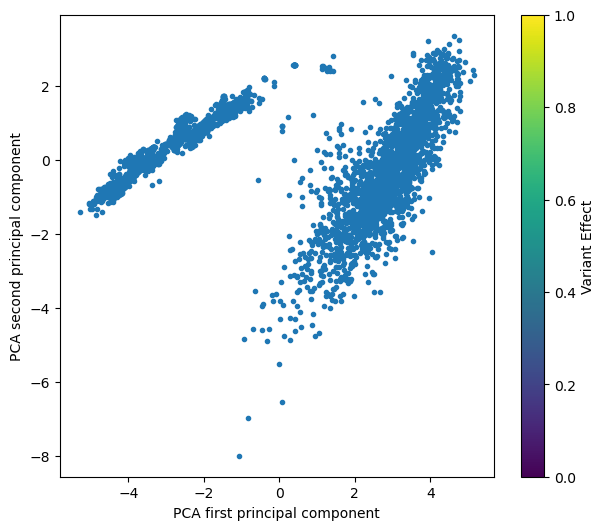

In [35]:
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')

### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [36]:
prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.05)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.025)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.10, keep=False)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.001, keep=False))
    ])

In [32]:
tr_hold = prep_pipeline[:5].fit_transform(tr)
tr_hold

,p1_E,p1_GAP,p1_H,p1_KRF,p1_M,p2_E,p2_G,p2_GAP,p2_H,p2_L,...,p384_D,p384_E,p384_G,p384_GAP,p385_E,p385_G,p385_GAP,p385_N,p385_SYPD,p385_T
Squid,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
S1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
S2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
S3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
S4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S151,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
S152,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
S153,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
S154,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [33]:
tr4 = tr_hold.merge(tr2,  left_index=True, right_index=True)
tr4.shape

(156, 2844)

In [34]:
tr5 = tr_hold.merge(tr3,  left_index=True, right_index=True)
tr5.shape

(156, 1664)

In [41]:
prep_pipeline = make_pipeline(
    steps=[
        #('pca', PCA(num_pca_components)),
        #('model', 'passthrough')
        ('cc', ConstantCare()),
        #('model', 'passthrough')

        #('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.10, keep=False)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.001, keep=False))
    ])

In [45]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)

['not_opsin' 'opsin']


In [57]:
report, top = model_compare_cv(X=tr2, y=y, preprocess_pipe=prep_pipeline,
                               models_dict=get_models(ana_type=ana_type),
                               scoring=get_scores(ana_type=ana_type),
                               report_dir=report_dir,
                               cv=10, ana_type=ana_type, cache_dir=None)

Fitting rf...
Fitting Adaboost...
Fitting et...
Fitting lg...
Fitting gbc...
Fitting dt...
Fitting xgb...
Fitting lgbm...


In [42]:
%%time
report, top = model_compare_cv(X=tr2, y=y, preprocess_pipe=prep_pipeline,
                               models_dict=get_models(ana_type=ana_type),
                               scoring=get_scores(ana_type=ana_type),
                               report_dir=report_dir,
                               cv=15, ana_type=ana_type, cache_dir=report_dir)

Fitting rf...
Fitting Adaboost...
Fitting et...
Fitting lg...
Fitting gbc...
Fitting dt...
Fitting xgb...


ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\xgboost\sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['not_opsin' 'opsin']


MAE = Mean Absolute Error

MSE = Mean Squared Error

RMSE = Rooted Mean Square Error

MAPE = Mean Absolute % Error - the average magnitude of error produced by a model, or how far off predictions are on average. A MAPE value of 20% means that the average absolute percentage difference between the predictions and the actuals is 20%

In [59]:
report

,Accuracy,AUC,F1,Recall,Precision
lgbm,0.998762,0.999007,0.998757,0.998793,0.998725
Adaboost,0.998515,0.999205,0.998510,0.998542,0.998482
gbc,0.998515,0.998870,0.998510,0.998542,0.998482
xgb,0.998515,0.999163,0.998510,0.998542,0.998482
lg,0.998515,0.999192,0.998510,0.998553,0.998471
rf,0.998267,0.999285,0.998262,0.998287,0.998243
et,0.998267,0.999302,0.998262,0.998287,0.998243
dt,0.996287,0.996348,0.996273,0.996348,0.996219


In [ ]:
prep_pipeline = make_pipeline(
    steps=[
        ('cc', ConstantCare()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.10, keep=True)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.001, keep=True))
    ])

In [60]:
modified_top = []
mtml = []
for model in top:
    modified_top.append(make_pipeline(steps=[('prep', prep_pipeline), model.steps[-1]]))
    my_top_models = str(model[1:])
    #print(my_top_models)
    my_top_models = my_top_models.split("'")[1]
    mtml.append(my_top_models)
    #print(my_top_models)

In [61]:
modified_top[0]

Pipeline(steps=[('prep',
                 Pipeline(steps=[('cc', ConstantCare()),
                                 ('collinear_care',
                                  CollinearCare(dist_method='correlation',
                                                threshold=0.001))])),
                ('lgbm', LGBMClassifier(random_state=123))])

In [62]:
%%time
top = finalize_top(X=tr3, y=y, top_models=modified_top, grid_param={},report_dir=report_dir, cv=10)


Tuning lgbm...
No Grid-Search Specified, fitting model to default parameters.
Tuning Adaboost...
No Grid-Search Specified, fitting model to default parameters.
Tuning gbc...
No Grid-Search Specified, fitting model to default parameters.
Tuning xgb...
No Grid-Search Specified, fitting model to default parameters.
Tuning lg...
No Grid-Search Specified, fitting model to default parameters.
CPU times: total: 22.1 s
Wall time: 17.4 s


In [56]:
import joblib
load_lgbm = joblib.load(report_dir+'/lg.pkl')

In [ ]:
load_lgbm.predict()

In [58]:
tr2[3]

KeyError: 3